### Practica 08: Análasis Estadisticos Avanzado de Datos Usando las Librerias: Scipy, itertools y wordcloud

Zamira Cuevas Zamora  Matricula : 220907

Asignatura: Extracción de Conocimientos de Base de Datos

#### Paso 1: Configuracion de librerias y instalacion 

In [53]:
%%time

# Instalación de bibliotecas seleccionadas:-
from gc import collect;  # recolección de basura para liberar memoria
from warnings import filterwarnings;  # manejo de mensajes de advertencia

import re  # expresiones regulares
# 
import numpy as np  # álgebra lineal
import pandas as pd  # procesamiento de datos, archivos CSV (ej. pd.read_csv)
from scipy import stats  # funciones estadísticas

from itertools import cycle, combinations  # generación de combinaciones y ciclos

import matplotlib.pyplot as plt  # visualización de datos
from matplotlib.ticker import FuncFormatter  # Para formato personalizado de marcas
from matplotlib.ticker import FormatStrFormatter  # Para formatear marcas con cadenas
from mpl_toolkits.mplot3d import Axes3D  # Módulo para ejes 3D
from matplotlib.colors import ListedColormap  # Mapa de colores para gráficos de dispersión
import seaborn as sns  # visualización estadística de datos
from wordcloud import WordCloud  # Biblioteca para visualización de datos textuales

from io import StringIO

filterwarnings('ignore');  # Ignorar mensajes de advertencia
from IPython.display import display, HTML, display_html, clear_output;  # mostrar contenido HTML


clear_output();
print();
collect();


CPU times: total: 250 ms
Wall time: 241 ms


In [54]:
# Define la clase de color para colorear el texto de la terminal
class color:
    GREEN = '\033[92m'
    END = '\033[0m'

# Then use your existing code
plt.style.use("fivethirtyeight")
sns.set(rc={"figure.figsize":(10, 10)})
print(f"{color.GREEN}Successfully Configured libraries!{color.END}")

Successfully Configured libraries!


## Paso 2.-  Cargar conjunto de datos

#### Cargamos la base de datos de tipo csv

In [56]:
%%time

try:
    df = pd.read_csv('salaries.csv')
    print(f"\033[92mDataset loaded successfully.\033[0m")
    
except FileNotFoundError:
    print(f"\033[91mError: File not found. Please check the file path.\033[0m")

except Exception as e:
    print(f"\033[91mAn error occurred while loading the dataset: {e}\033[0m")

print("\033[94m")
collect()

Dataset loaded successfully.

CPU times: total: 594 ms
Wall time: 597 ms


0

### Paso 3- Descripción general de atributos

In [57]:
### Defina primero la función que falta
def display_dataframe_with_custom_header(df, show_head=False):
    """
    Mostrar información sobre un marco de datos o su encabezado
    
    Parameters:
    df (pandas.DataFrame): The dataframe to display
    show_head (bool): If True, display the first few rows of the dataframe
                     If False, display dataframe info
    """
    if show_head:
        display(df.head())  
    else:
        display(df.info()) 

# Ahora usa la función
display_dataframe_with_custom_header(df)  
display_dataframe_with_custom_header(df, show_head=True) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73164 entries, 0 to 73163
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   work_year           73160 non-null  float64
 1   experience_level    73162 non-null  object 
 2   employment_type     73162 non-null  object 
 3   job_title           73160 non-null  object 
 4   salary              73155 non-null  float64
 5   salary_currency     73157 non-null  object 
 6   salary_in_usd       73152 non-null  float64
 7   employee_residence  73158 non-null  object 
 8   remote_ratio        73157 non-null  float64
 9   company_location    73155 non-null  object 
 10  company_size        73159 non-null  object 
dtypes: float64(4), object(7)
memory usage: 6.1+ MB


None

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,NaN,SXE,NaN,NaN,NaN,NaN,NaN,US,NaN,NaN,M
1,NaN,SE,FT,Engineer,NaN,NaN,NaN,US,0.0,US,M
2,2025.0,SE,FT,Data Product Owner,110000.0,USD,110000.0,US,0.0,US,M
3,2025.0,SE,FT,Data Product Owner,170000.0,USD,170000.0,US,0.0,US,M
4,2025.0,SE,FT,Data Product Owner,110000.0,USD,110000.0,US,0.0,US,M


### Paso 4.-  Manejo de valores faltantes

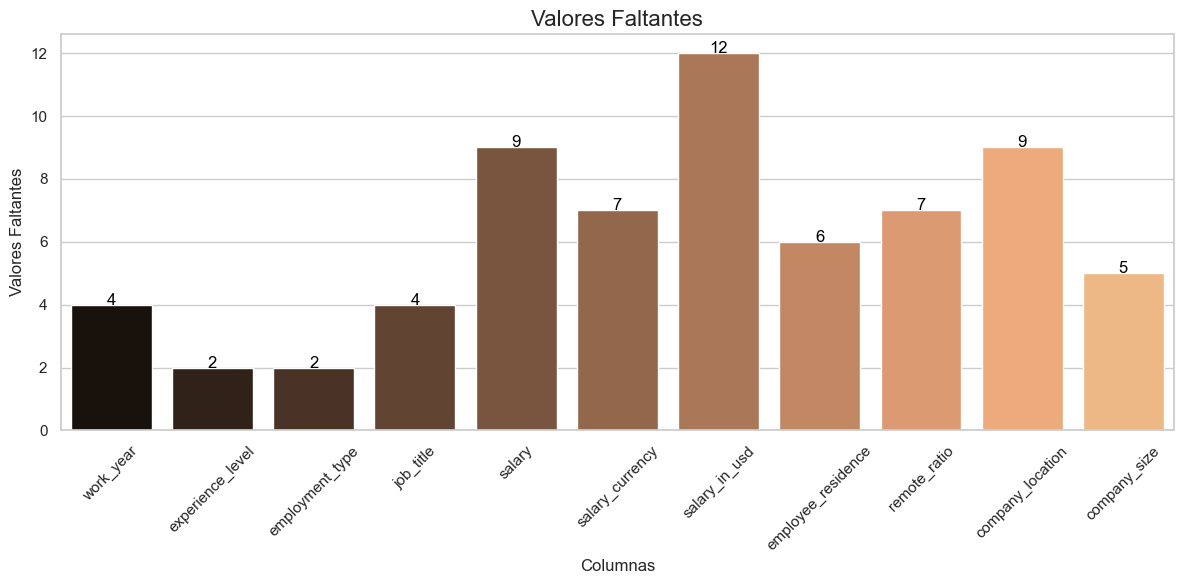

In [58]:
# Calcular la cantidad de valores faltantes por columna
missing_values = df.isnull().sum()

# Crear un DataFrame para graficar
missing_df = pd.DataFrame({
    'Columnas': missing_values.index,
    'Valores Faltantes': missing_values.values
})

# Estilo de gráfico
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
barplot = sns.barplot(
    x="Columnas", 
    y="Valores Faltantes", 
    data=missing_df,
    palette="copper"
)

# Mostrar número de valores faltantes sobre cada barra
for index, row in missing_df.iterrows():
    barplot.text(index, row["Valores Faltantes"], int(row["Valores Faltantes"]), color='black', ha="center")

# Título y formato
plt.title("Valores Faltantes", fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###  Paso 5.- Eliminacion de los valores duplicados

In [60]:
# Definir códigos de color ANSI
BLUE = '\033[94m'
RED = '\033[91m'
BOLD = '\033[1m'
END = '\033[0m'

duplicate_values = df.duplicated().sum()
print(f"{BLUE}The data contains {BOLD}{RED}{duplicate_values}{END}{BLUE} duplicate values{END}")


The data contains 39124 duplicate values


In [61]:
# Crear diccionario: True si la columna NO tiene duplicados, False si sí tiene
sin_duplicados = {
    columna: df[columna].duplicated().sum() == 0
    for columna in df.columns
}

# Convertir a DataFrame
df_sin_duplicados = pd.DataFrame.from_dict(sin_duplicados, orient='index', columns=['No Duplicates'])

# Mostrar como tabla estilizada con colores (verde si True, rojo si False)
df_sin_duplicados.style.applymap(lambda x: 'color: green' if x else 'color: red')

,No Duplicates
work_year,False
experience_level,False
employment_type,False
job_title,False
salary,False
salary_currency,False
salary_in_usd,False
employee_residence,False
remote_ratio,False
company_location,False


### Paso 6.- Resumen de datos estadísticos

In [62]:
def calculate_statistics(df, opacity=0.4, font_size='14px'):
    # Seleccionar sólo columnas numéricas
    numeric_df = df.select_dtypes(include=['number'])
    
    # # Calcular estadísticas solo para columnas numéricas
    stats = pd.DataFrame({
        'Mean': numeric_df.mean(),
        'Median': numeric_df.median(),
        'Mode': numeric_df.mode().iloc[0],
        'Range': numeric_df.max() - numeric_df.min(),
        'Stdev': numeric_df.std(),
        'Variance': numeric_df.var(),
        'IQR': numeric_df.quantile(0.75) - numeric_df.quantile(0.25),
        '25%': numeric_df.quantile(0.25),
        '50%': numeric_df.quantile(0.5),
        '75%': numeric_df.quantile(0.75),
        'Min': numeric_df.min(),
        'Max': numeric_df.max(),
        'Skewness': numeric_df.skew(),
        'Kurtosis': numeric_df.kurtosis()
    }).T

    # Se le da estilos
    styled_stats = stats.style.set_properties(**{
        'background-color': f'rgba(173, 216, 230, {opacity})',
        'font-size': font_size,
        'text-align': 'center'
    }).set_table_styles([
        {'selector': 'th', 'props': [('font-weight', 'bold'), ('background-color', 'white'), ('color', 'black'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('border', '1px solid #bbb')]},
        {'selector': 'caption', 'props': [('caption-side', 'bottom'), ('font-size', '16px'), ('color', '#555')]}
    ]).set_caption("Estadísticas Descriptivas por Columna")

    return styled_stats


### Mandamos a llamar la funcion para la tabla

In [63]:
stats_df = calculate_statistics(df, opacity=0.4, font_size='19px')
stats_df

,work_year,salary,salary_in_usd,remote_ratio
Mean,2023.831219,162565.352402,158011.634938,21.583034
Median,2024.000000,148000.000000,147500.000000,0.000000
Mode,2024.000000,160000.000000,160000.000000,0.000000
Range,5.000000,30395000.000000,795000.000000,100.000000
Stdev,0.478032,192592.531569,72519.727826,41.021454
Variance,0.228515,37091883216.145042,5259110923.963512,1682.759703
IQR,0.000000,93045.000000,92810.000000,0.000000
25%,2024.000000,106955.000000,106890.000000,0.000000
50%,2024.000000,148000.000000,147500.000000,0.000000
75%,2024.000000,200000.000000,199700.000000,0.000000


### Resumen de variables

In [64]:
def variable_summary(df):
    # Crear el resumen de variables
    summary = pd.DataFrame({
        'Variable': df.columns,
        'Dtype': df.dtypes.values,
        'Count': [len(df)] * len(df.columns), 
        'Unique': df.nunique().values,
        'Missing': df.isnull().sum().values
    })
    
    # Aplicar el estilo similar a la imagen
    styled = summary.style \
        .set_properties(**{
            'text-align': 'left',
            'font-size': '12px',
            'border': '1px solid #e0e0e0',
            'padding': '4px 8px'
        }) \
        .set_table_styles([
            {'selector': 'th', 
             'props': [
                 ('background-color', '#f8f9fa'),
                 ('color', '#202124'),
                 ('font-weight', 'bold'),
                 ('border', '1px solid #e0e0e0'),
                 ('padding', '8px 16px')
             ]},
            {'selector': 'td', 
             'props': [
                 ('border', '1px solid #e0e0e0'),
                 ('padding', '8px 16px')
             ]},
            {'selector': 'tr:hover', 
             'props': [
                 ('background-color', '#f1f3f4')
             ]}
        ]) \
        .hide(axis='index')  # Ocultar el índice
    
    return styled

# Llamar a la función con tu DataFrame
summary_df = variable_summary(df)
summary_df

Variable,Dtype,Count,Unique,Missing
work_year,float64,73164,6,4
experience_level,object,73164,5,2
employment_type,object,73164,4,2
job_title,object,73164,291,4
salary,float64,73164,7101,9
salary_currency,object,73164,26,7
salary_in_usd,float64,73164,7708,12
employee_residence,object,73164,93,6
remote_ratio,float64,73164,3,7
company_location,object,73164,86,9
